In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy, AUC
from sklearn.model_selection import train_test_split

In [2]:
# Add an additional column, mapping to the type
Image_info_df = pd.read_csv('../Data/Gaussian_Retina_Data/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


Image_info_df['binary_type'] =  Image_info_df['diagnosis'].map(diagnosis_dict_binary.get)
Image_info_df['type'] = Image_info_df['diagnosis'].map(diagnosis_dict.get)
Image_info_df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


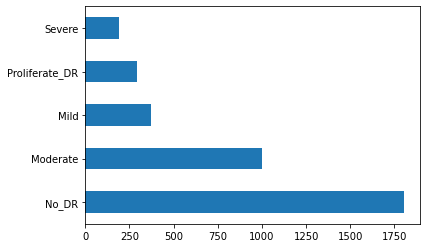

In [3]:
# Show how many of each type of retinopathy
Image_info_df['type'].value_counts().plot(kind='barh')

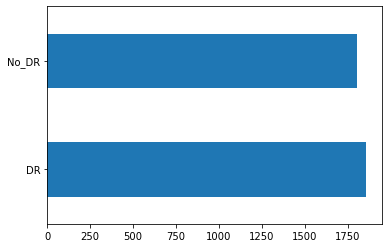

In [4]:
# Show the balance between no retinopathy and stages of retinopathy
Image_info_df['binary_type'].value_counts().plot(kind='barh')

In [16]:
# Split into train, and test sets
train, test = train_test_split(Image_info_df, test_size = 0.20)
T1, T2 = train_test_split(test, test_size = 0.033)

# Show how many in each set
print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(T1['type'].value_counts(), '\n')
print(T2['type'].value_counts(), '\n')

No_DR             1446
Moderate           796
Mild               301
Proliferate_DR     226
Severe             160
Name: type, dtype: int64 

No_DR             359
Moderate          203
Mild               69
Proliferate_DR     69
Severe             33
Name: type, dtype: int64 

No_DR             353
Moderate          192
Proliferate_DR     66
Mild               65
Severe             32
Name: type, dtype: int64 

Moderate          11
No_DR              6
Mild               4
Proliferate_DR     3
Severe             1
Name: type, dtype: int64 



In [17]:
# Create working directories for train/val/test
base_dir = ''

T1_dir = os.path.join(base_dir, 'T1')
T2_dir = os.path.join(base_dir, 'T2')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(T1_dir):
    shutil.rmtree(T1_dir)
os.makedirs(T1_dir)

if os.path.exists(T2_dir):
    shutil.rmtree(T2_dir)
os.makedirs(T2_dir)


In [18]:
# Copy images to respective working directory
src_dir = '../Data/Gaussian_Retina_Data/gaussian_filtered_images/gaussian_filtered_images/'
for index, row in T1.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(T1_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in T2.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(T2_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [19]:
# Setting up ImageDataGenerator for train/val/test 

T1_path = 'T1'
T2_path = 'T2'

T1_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(T1_path, target_size=(224,224), shuffle = False)
T2_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(T2_path, target_size=(224,224), shuffle = False)

Found 708 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [20]:
train.head(5)

,id_code,diagnosis,binary_type,type
2599,b498b84d383f,2,DR,Moderate
3335,e76a9cbb2a8c,3,DR,Severe
2846,c597ef460944,0,No_DR,No_DR
1948,894a37fc3738,0,No_DR,No_DR
3407,ec6f1797a25a,0,No_DR,No_DR


In [10]:
test.head(5)

,id_code,diagnosis,binary_type,type
297,1632c4311fc9,2,DR,Moderate
1487,683023cda6a5,0,No_DR,No_DR
1049,4ad6109706e8,2,DR,Moderate
1679,76cb010f7aa0,0,No_DR,No_DR
1924,87774aafe068,4,DR,Proliferate_DR


In [12]:
T2

,id_code,diagnosis,binary_type,type
3488,f2ee81781411,2,DR,Moderate
552,2735be026d44,2,DR,Moderate
1787,7e70344b0c25,0,No_DR,No_DR
3547,f6f7dba7104d,1,DR,Mild
2347,a44345b27804,0,No_DR,No_DR
...,...,...,...,...
1320,5b994ff78547,0,No_DR,No_DR
2373,a64273801bde,2,DR,Moderate
244,12058bbb8299,0,No_DR,No_DR
1161,5152bf091152,2,DR,Moderate
